## Preprocessing

In [53]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import json
import time
import random

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Let's define the hyperparameters and complete the necessary preprocessing steps.

In [54]:
TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1
TIME_WINDOW_SIZE = 12
EPOCHS = 5

NUMBER_OF_CLIENTS = 10 # Controls the number of households used for forecasting.
FL_ROUNDS = 10 # Controls the number of federated learning rounds.
N_CLUSTERS = 4 # Controls the number of total clusters that exist in the data. Increasing it may make the results more accurate with an additional computational cost.
N_CLUSTER_IDS = 1 # Controls the number of cluster identities of a client, in case a soft clustering approach is desired. 1 is the original value of IFCA, which applies hard clustering.

In [55]:
def load_data():
    df = pd.read_csv('combined.csv', parse_dates=[1])
    return df

def basic_preprocess_fn(df:pd.DataFrame):
    """ Selects the electricity data with standard tariffs belonging to year 2013 and sorts the dataframe based on 
    DateTime column. """
    
    temp = df[df['DateTime'].dt.strftime('%Y') == '2013'].sort_values(by=['DateTime'])
    #temp = temp[temp['stdorToU'] == 'Std']
    #temp = temp.drop(axis=1, columns = 'stdorToU')
    return temp

def extract_clients(df:pd.DataFrame):
    """ Extracts client ids and client data from the given dataframe, which is assumed to hold multiple 
    client information."""
    
    client_keys = df['LCLid'].value_counts().keys().tolist()
    client_list = []

    for key in client_keys:
        client_df = df[df['LCLid'] == key]
        client_list.append(client_df)

    return client_keys, client_list

def resample_fn(df:pd.DataFrame):
    """ Resamples the time-series dataframe so that it reflects hourly electricity consumption values. It also does
    basic data processing such as dropping unnecessary columns. """
    
    resample_df = df.astype({"KWH/hh (per half hour) ": float}).drop(columns = ['LCLid']).set_index('DateTime').resample(rule='H').sum()
    resample_df.rename(columns = {'KWH/hh (per half hour) ':'kWh'}, inplace = True)
    return resample_df

def remove_bad_clients(client_keys:list, client_list:list):
    """ Drops the clients with datapoints fewer than 0.9 percent of the client with highest amount of data. """
    
    sizes = [len(e) for e in client_list]
    biggest_client = max(sizes) 
    ratios = [size/biggest_client for size in sizes]
    indices_to_keep = [idx for idx,e in enumerate(ratios) if e>=0.9]
    
    client_keys_selected = [client_keys[index] for index in indices_to_keep]
    client_list_selected = [client_list[index] for index in indices_to_keep]
    
    return client_keys_selected, client_list_selected

def create_client_dict(client_keys, client_data_list):
    """ Matches every client ID with its own electricty consumption data and returns the pairs in a python dictionary. """
    client_dict = {}
    for key, df in zip(client_keys, client_data_list):
        client_dict[key] = df
        
    return client_dict

In [56]:
df = load_data()
temp = basic_preprocess_fn(df)
client_keys, client_list = extract_clients(temp)
client_list_resampled = list(map(resample_fn, client_list))
client_keys_selected, client_list_selected = remove_bad_clients(client_keys, client_list_resampled)
client_dict = create_client_dict(client_keys_selected, client_list_selected)

## Creating the Client Class

We will now define the client class and its attributes. Explaining the attributes of the Client and Server classes will make this notebook very lengthy in size, so it's better to check the IFCA paper if you'd like to understand its workflow.

In [57]:
class Client:
    def __init__(self, cid, data, round_id = None):
    
        self.cid = cid
        self.df = data
        self.round_id = round_id
        #self.train_loss_hist   = []
        #self.val_loss_hist     = []
        #self.predictions_hist  = []
        #self.test_metrics_hist = []
        #self.weights_hist = []
        self.cluster_ids = list(np.ones((N_CLUSTER_IDS,), dtype=int))

    def create_model(self): # Can be changed to a lighter model for fast experimentation.
        """ Initialize an LSTM model."""
        self.model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, dropout=0.1, batch_input_shape=(None,12,1), return_sequences=True),
        tf.keras.layers.LSTM(16, dropout=0.1),
        tf.keras.layers.Dense(1),
        ])
        return self.model
    
    def train_test_val_split(self):
        """ Splits the client data into train, test and validation datasets. """

        df_size = self.df.shape[0]

        self.train = self.df.iloc[:int(df_size * 0.7)]
        self.val = self.df.iloc[int(df_size * 0.7):int(df_size * 0.9)]
        self.test = self.df.iloc[int(df_size * 0.9):]

        return self.train, self.val, self.test
    
    def normalize_fn(self, scaler = MinMaxScaler()):
        """ Normalizes the input arrays with the given scaler. Train array is taken as the reference. """

        self.train_sc = scaler.fit_transform( self.train.values )
        self.val_sc = scaler.transform( self.val.values )
        self.test_sc = scaler.transform( self.test.values )
        self.scaler = scaler
        
        return self.train_sc, self.val_sc, self.test_sc, self.scaler
    
    def create_tensor_datasets(self):
        """ Applies the window function on the scaled train,test and validation arrays. Output will be tf.data datasets."""
        
        def window_fn(input_array, window_size=TIME_WINDOW_SIZE, batch_size=TRAIN_BATCH_SIZE):
            """ Creates time series windows for the given input array and returns them as a batch of tensorflow dataset."""
            dataset = tf.data.Dataset.from_tensor_slices(input_array)
            dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
            dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
            dataset = dataset.map(lambda window: (window[:-1], window[-1:]), num_parallel_calls=10)
            dataset = dataset.batch(batch_size, num_parallel_calls=10).prefetch(1)

            return dataset
    
        self.train_tf = window_fn(self.train_sc, window_size = TIME_WINDOW_SIZE)
        self.val_tf = window_fn(self.val_sc, window_size = TIME_WINDOW_SIZE)
        self.test_tf = window_fn(self.test_sc, window_size = TIME_WINDOW_SIZE)
        self.dataset_tf = window_fn(self.df, window_size=12)

        return self.train_tf, self.val_tf, self.test_tf, self.dataset_tf
        
    def train_fn(self, lr = 0.002, opt = tf.keras.optimizers.Adam, epochs = EPOCHS):
        """ Fits the model on train&validation data and returns the corresponding MSE loss values. """
        model = self.model
        train = self.train_tf
        validation = self.val_tf
        
        learning_rate = lr
        optimizer = opt(learning_rate = lr)
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mse"])

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit(x=train, epochs=epochs, validation_data=validation, callbacks=[callback], verbose=False)
        # self.train_loss = history.history['loss']
        self.val_loss = history.history['val_loss']

        #self.train_loss_hist.append(self.train_loss)
        #self.val_loss_hist.append(self.val_loss)
        return #self.train_loss, self.val_loss
    
    def evaluate(self):
        """ Evaluate the trained local model on local test set, return predicstions and test MSE."""
        #new_model = tf.keras.models.Sequential([
        #tf.keras.layers.LSTM(32, dropout=0.1, batch_input_shape = (1,12,1), return_sequences=True),
        #tf.keras.layers.LSTM(16, dropout=0.1),
        #tf.keras.layers.Dense(1),
        #])
        #new_model.set_weights(self.model.get_weights())

        forecast = self.model.predict(self.test_tf)
        self.predictions = self.scaler.inverse_transform(forecast)
        self.pred_df = pd.DataFrame(data = self.predictions, columns = list(self.df.columns.values))
        self.test_metrics = round(mean_squared_error(self.test[TIME_WINDOW_SIZE:], self.predictions), 5)
        self.test_metrics_pct = round(mean_absolute_percentage_error(self.test[TIME_WINDOW_SIZE:], self.predictions), 5)
        self.r2 = round(r2_score(self.test[TIME_WINDOW_SIZE:], self.predictions), 5)

        #self.predictions_hist.append(self.predictions)
        #self.test_metrics_hist.append(self.test_metrics)
        return #self.predictions, self.test_metrics
    
    def detect_clusters(self, model_dict, n=N_CLUSTER_IDS):
        dataset_whole = self.dataset_tf
        cluster_model_losses = {}

        for cluster, model in model_dict.items():
          """ Block iterating over cluster models and calculating their respective loss on the current client's dataset. """  
          dataset_whole_loss = model.evaluate(dataset_whole, verbose=False)
          cluster_model_losses[cluster] = dataset_whole_loss[0]

        """ Sort and extract the best cluster model(the one with minimum MSE loss) among available ones. """
        sorted_cluster_model_losses = {k: v for k, v in sorted(cluster_model_losses.items(), key=lambda x: x[1])}
        best_n_clusters = list(sorted_cluster_model_losses)[:n]
        self.cluster_ids = best_n_clusters
        print(self.cluster_ids)
        best_model_key = min(sorted_cluster_model_losses, key=sorted_cluster_model_losses.get)
        return self.cluster_ids

    def get_cluster_models(self, model_dict):
        models_to_select = list( map(model_dict.get, self.cluster_ids) )
        self.model_weights = [m.get_weights() for m in models_to_select]
        #print(self.cluster_ids, self.model_weights)
        return

    def average_cluster_models(self):
        self.cluster_weights_avg = np.mean( np.array(self.model_weights, dtype=object), axis = 0)
        #print(self.cluster_weights_avg)
        return

    def set_weights(self):
        """ Set the model weights taken from the server."""
        self.model.set_weights(self.cluster_weights_avg)
        return 
    
    def send_weights(self):
        """ Send the local model's weights to server. """
        weights = np.array(self.model.get_weights(), dtype=object)

        self.weights_hist.append(weights)
        return weights

## Server

Similar to the Client class, Server class too is a complex one. Check the original IFCA paper, or the thesis itself if you want to understand how the coordination process happens in IFCA.

We also need to add the instantiation function that gets a client dictionary and transforms all of its elements into a client object, which are then stored in a list. 

In [58]:
def instantiate_clients(client_dict):
    """ Takes a dictionary of client, client_data pairs and returns a list of client objects. """
    
    client_objects = []
    for client, data in client_dict.items():
        instance = Client(cid = client, data = data.iloc[:4380]) # Changed to a subset of data for fast experimentation.
        client_objects.append(instance)
    return client_objects
    
class Server:
  def __init__(self, num_rounds):
    self.number_of_rounds = num_rounds
    self.current_rnd = 0
    self.mses_overall = []
    self.r2_overall = []
    self.mapes_overall = []

  def create_model(self):
    """ Initialize an LSTM model which will be cloned for every cluster. """

    selected_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, dropout=0.1, kernel_initializer=selected_initializer, batch_input_shape=(None,12,1), return_sequences=True),
    tf.keras.layers.LSTM(16, dropout=0.1, kernel_initializer=selected_initializer),
    tf.keras.layers.Dense(1, kernel_initializer=selected_initializer),
    ])

    lr =  0.002
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
    return model

  def initialize_cluster_models(self):
    self.model_dict = {}

    for i in range(1,N_CLUSTERS):
      model = self.create_model()
      self.model_dict[i] = model
    return self.model_dict

  def initialize_clients(self, client_instances):
    """ Takes a list of client instances and configures their data and model
    for training."""

    for cl in client_instances:
      cl.create_model()
      cl.train_test_val_split()
      cl.normalize_fn()
      cl.create_tensor_datasets()

    return client_instances

  def create_cluster_weight_dict(self):
    self.cluster_weights_dict = {}
    for i in range(1,N_CLUSTERS):
      self.cluster_weights_dict[i] = []

  def federated_round(self, client_instances):
    """ Runs a clustered federated round, where every client trains&evaluates 
    current their model."""

    for i in range(self.number_of_rounds):
      self.create_cluster_weight_dict()
      print('____ROUND{}'.format(i+1))
      print('Detecting Clusters For Clients')
      for cl in client_instances:
        cl.detect_clusters(self.model_dict)
        cl.get_cluster_models(self.model_dict)
        cl.average_cluster_models()
        cl.set_weights()
      
      print('*'*50)

      print('Training&Evaluating the Averaged Cluster Model for Clients')
      round_test_mses = []
      round_test_mapes = []
      round_test_r2s = []
      for cl in client_instances:
        cl.train_fn()
        cl.evaluate()
        round_test_mses.append(cl.test_metrics)
        round_test_r2s.append(cl.r2)
        round_test_mapes.append(cl.test_metrics_pct)
      mean_mse = round(np.mean(round_test_mses), 4)
      mean_mape = round(np.mean(round_test_mapes), 4)
      mean_r2 = round(np.mean(round_test_r2s), 4)
      self.mses_overall.append(mean_mse)
      self.mapes_overall.append(mean_mape)
      self.r2_overall.append(mean_r2)

      print('Getting Client Model Weights')
      for cl in client_instances:
        for id in cl.cluster_ids:
          self.cluster_weights_dict[id].append(cl.model.get_weights())

      print('Averaging Model Weights inside every Cluster')
      for id, w in self.cluster_weights_dict.items():
        if len(w) != 0:
          w_new = self.average_weights(self.cluster_weights_dict[id])
          self.cluster_weights_dict[id] = w_new

      print('Updating the Weights in Server Model Dictionary')
      for k1,k2 in zip(self.model_dict.keys(), self.cluster_weights_dict.keys()):
        if k1==k2:
          if len(self.cluster_weights_dict[k2])!=0:
            self.model_dict[k1].set_weights(self.cluster_weights_dict[k2])

  def average_weights(self, cl_weights_list):
    """ Takes a list of client weights and averages them. """
    weights_avg = np.mean( np.array(cl_weights_list, dtype=object), axis = 0)
    return weights_avg

## Experiments

These cells are quite self-explanatory. Maybe the only oddity is that every client sticking to Cluster I, but such identites may change at every round in your experiments due to the randomness while the cluster models are being initialized.

In [59]:
server = Server(FL_ROUNDS)

In [60]:
client_objects = instantiate_clients(client_dict)
random.seed(10)
client_objects_short = random.sample(client_objects, NUMBER_OF_CLIENTS)

In [61]:
cluster_models_dict = server.initialize_cluster_models()
client_objects_short = server.initialize_clients(client_objects_short)

In [62]:
server.federated_round(client_objects_short)

____ROUND1
Detecting Clusters For Clients
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
**************************************************
Training&Evaluating the Averaged Cluster Model for Clients
Getting Client Model Weights
Averaging Model Weights inside every Cluster
Updating the Weights in Server Model Dictionary
____ROUND2
Detecting Clusters For Clients
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
**************************************************
Training&Evaluating the Averaged Cluster Model for Clients
Getting Client Model Weights
Averaging Model Weights inside every Cluster
Updating the Weights in Server Model Dictionary
____ROUND3
Detecting Clusters For Clients
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
**************************************************
Training&Evaluating the Averaged Cluster Model for Clients
Getting Client Model Weights
Averaging Model Weights inside every Cluster
Updating the Weights in Server Model Dictionary
____ROUND4
Detecting Clusters For Clients
[2]
[2]
[2]
[2]


## Clients' Test MSE Scores

Average test MSE over all clients: 0.2297
Average test R2 over all clients: -1.626


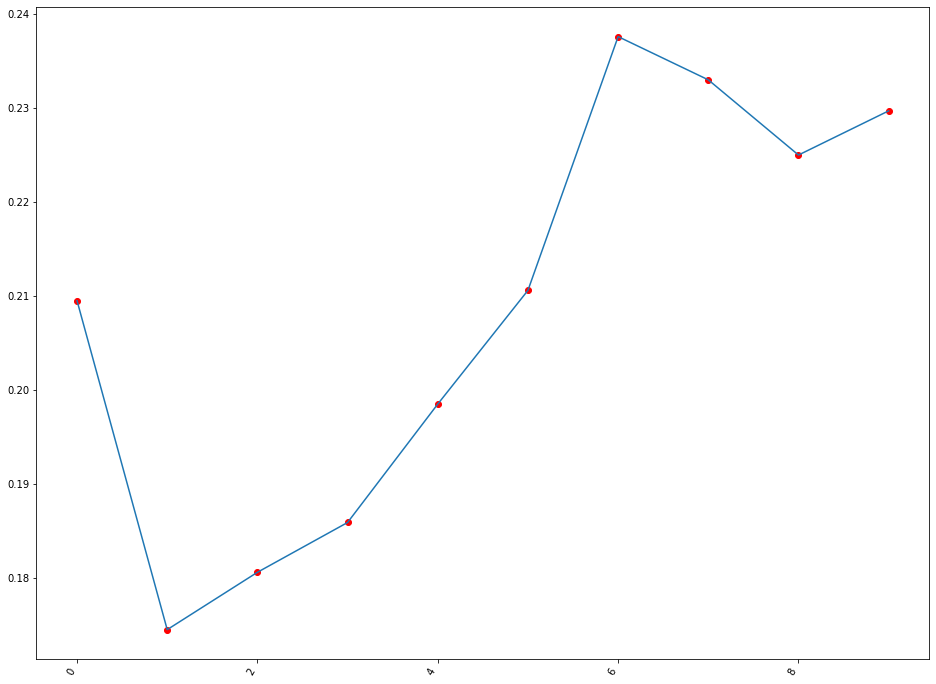

In [65]:
print('Average test MSE over all clients:', server.mses_overall[-1])
print('Average test R2 over all clients:', server.r2_overall[-1])

rounds = [int(i) for i in range(FL_ROUNDS)]
plt.plot(rounds, server.mses_overall)
plt.scatter(x=rounds, y=server.mses_overall, color='r')
plt.xticks(rotation=60, ha='right')
plt.show()
plt.close()

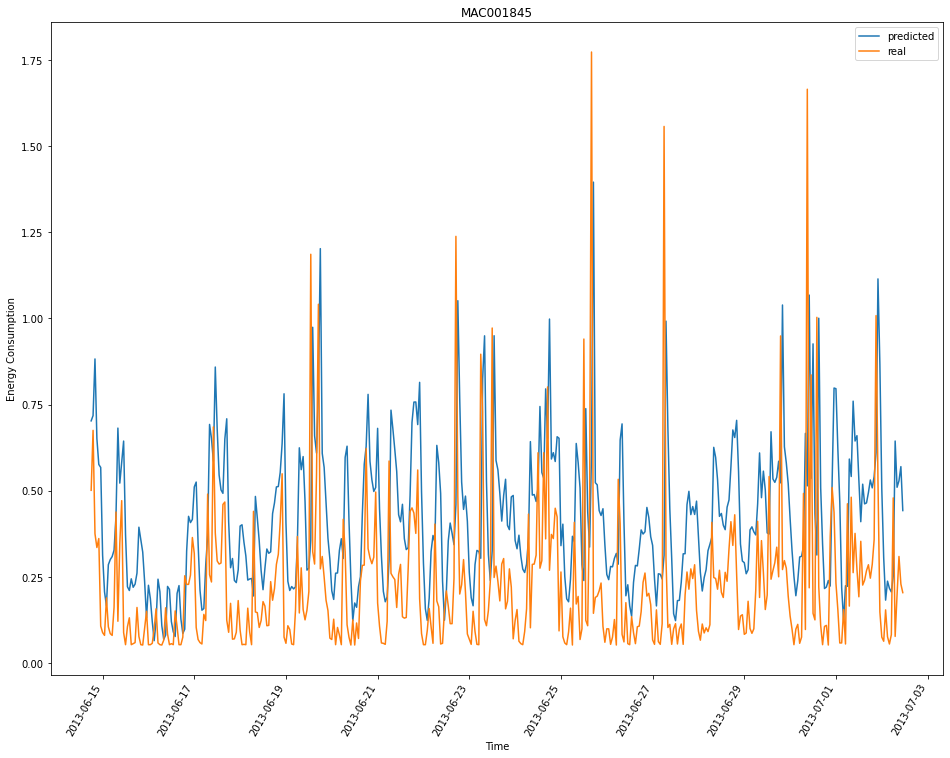

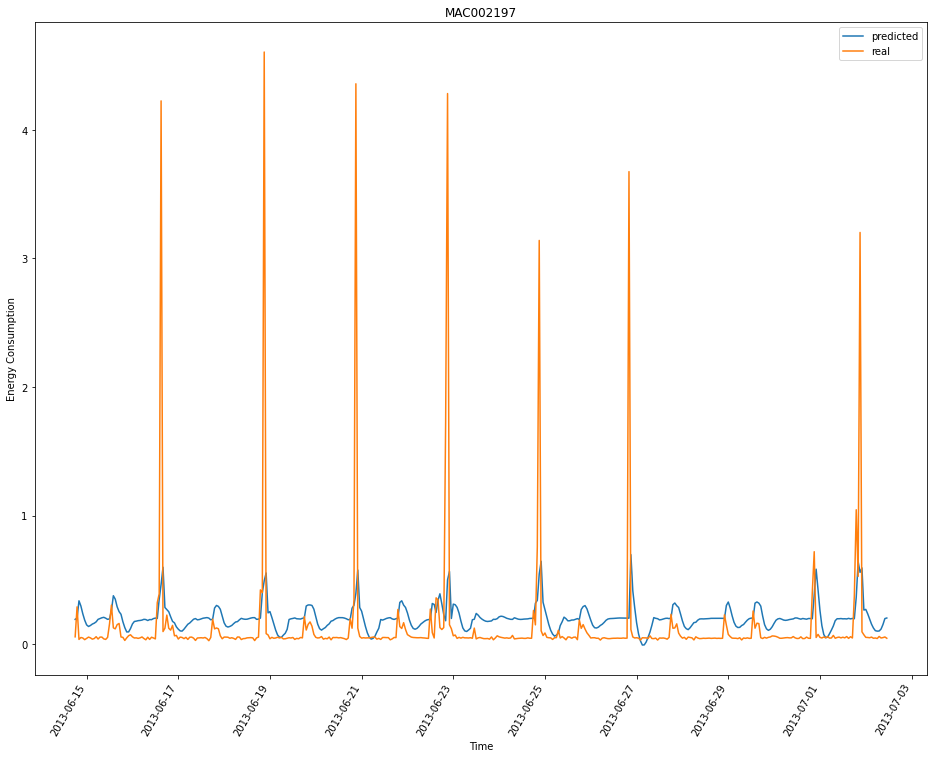

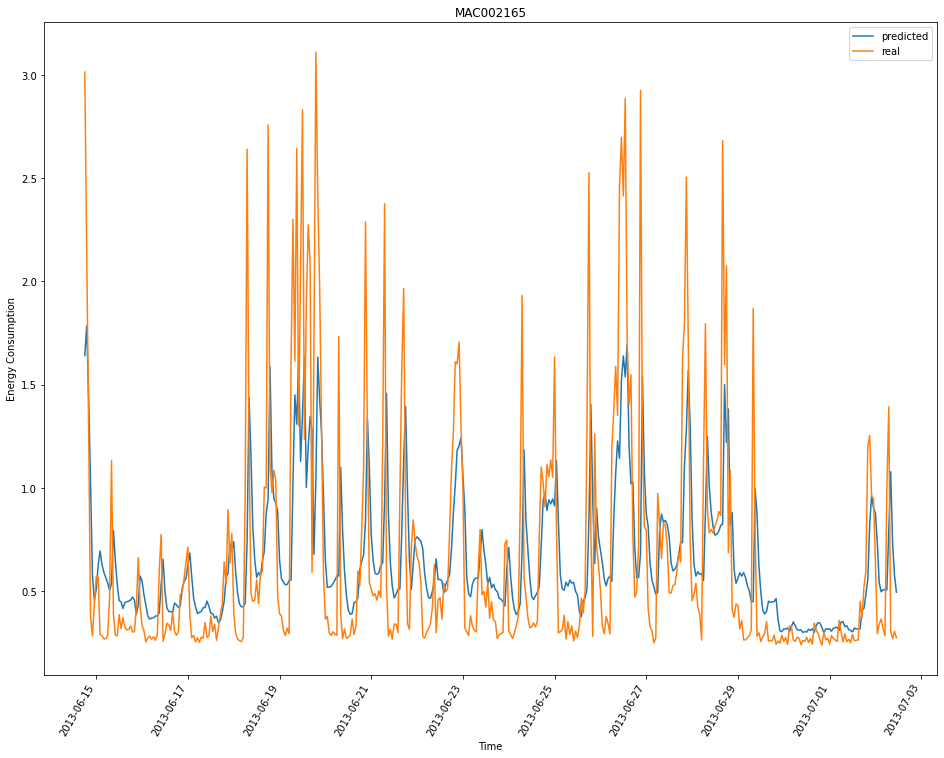

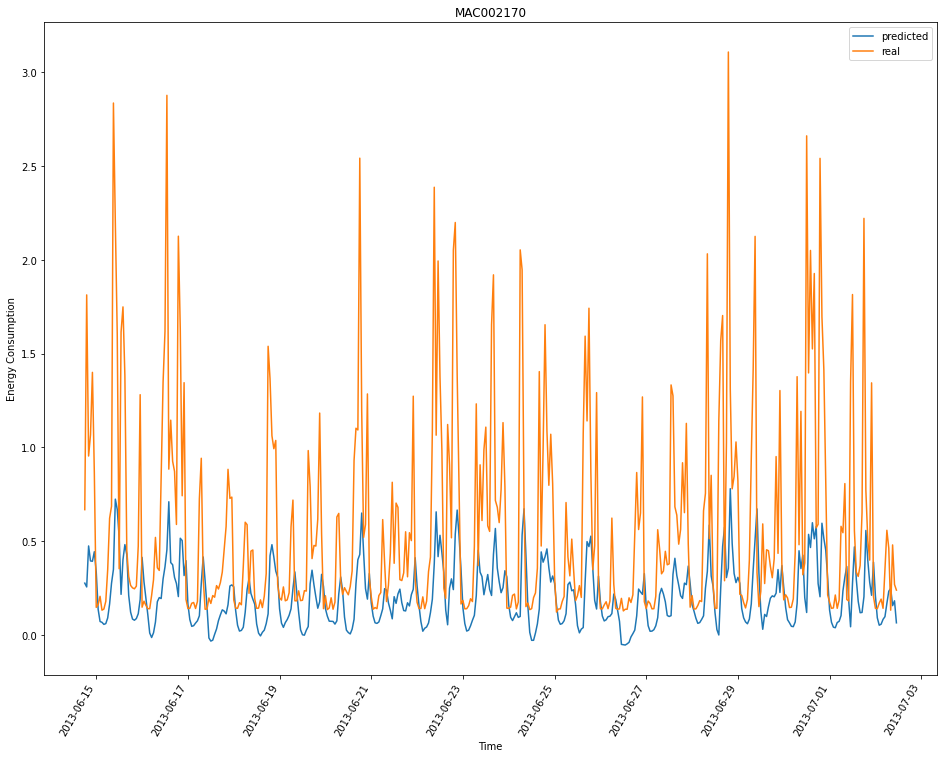

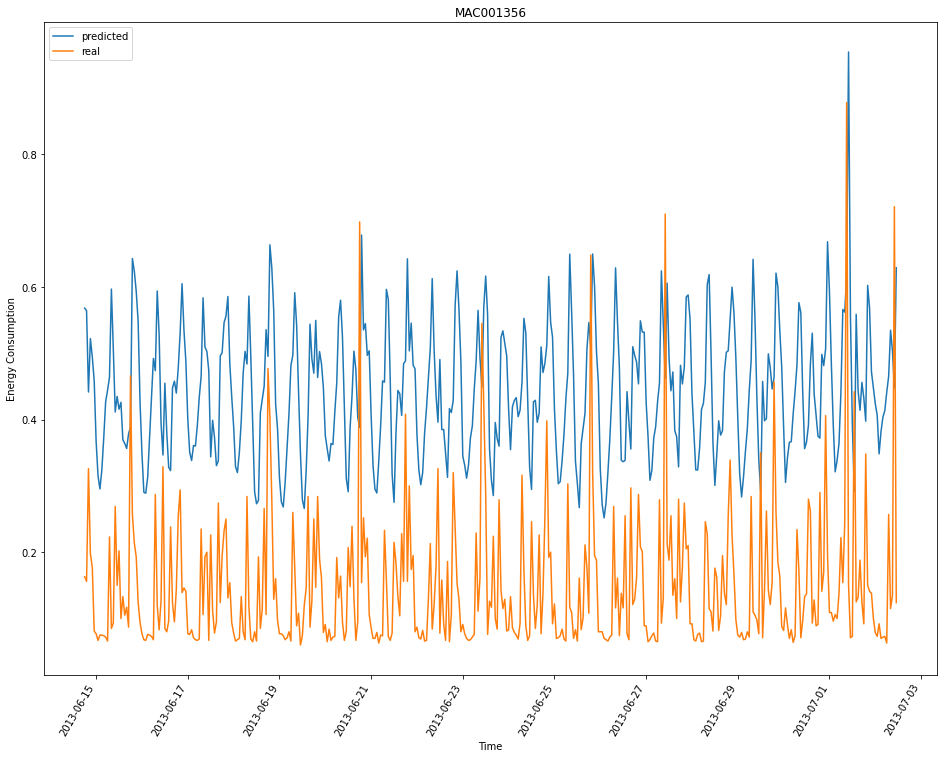

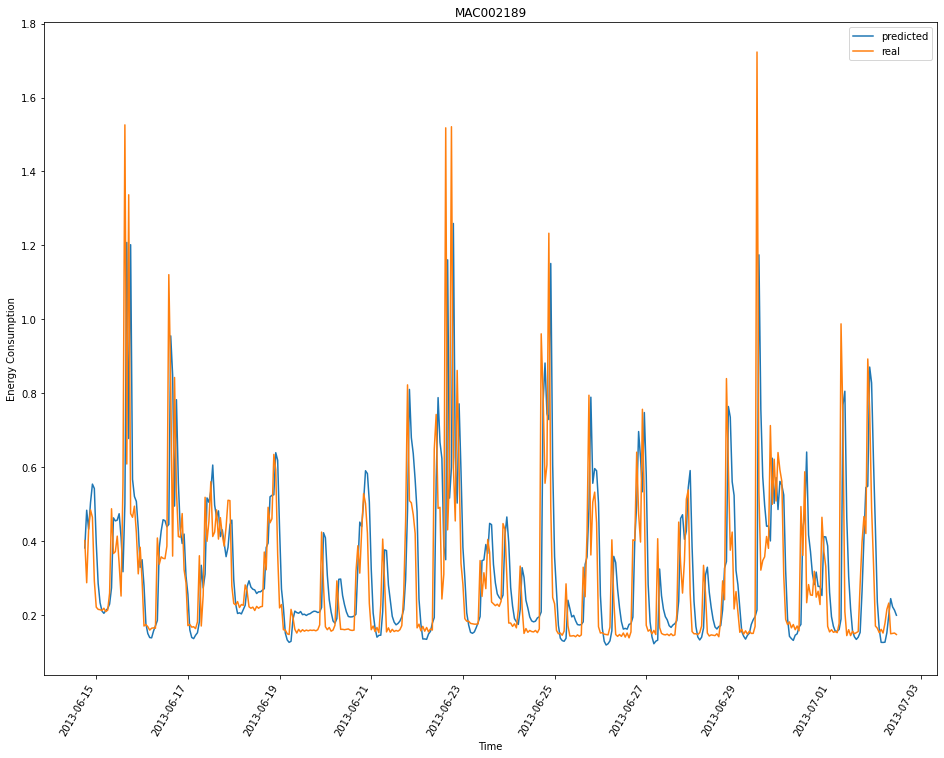

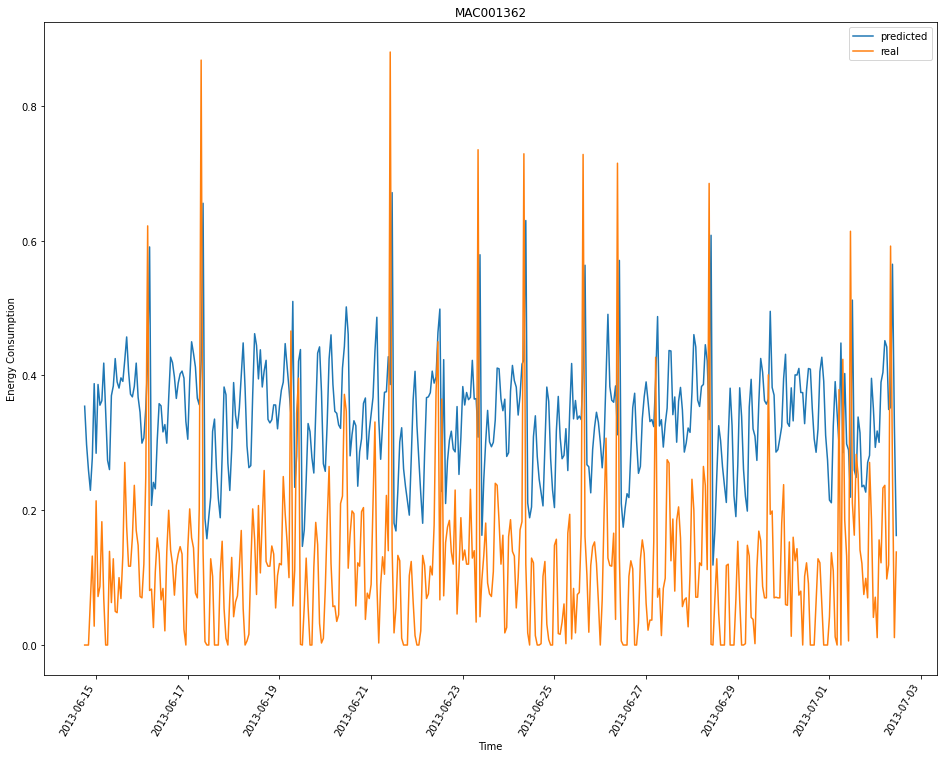

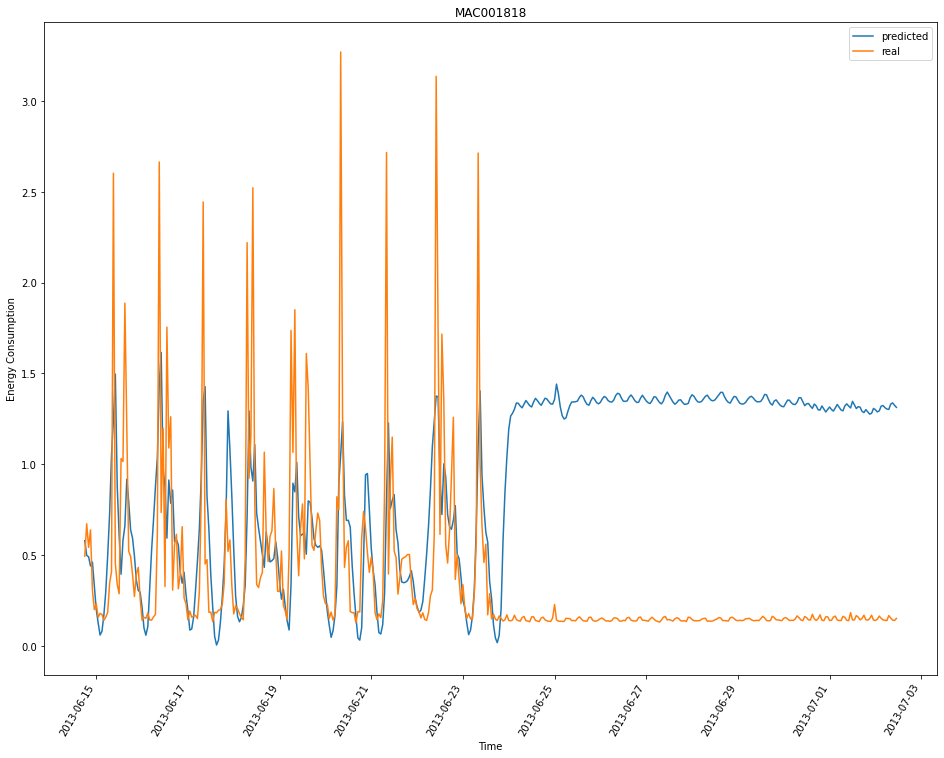

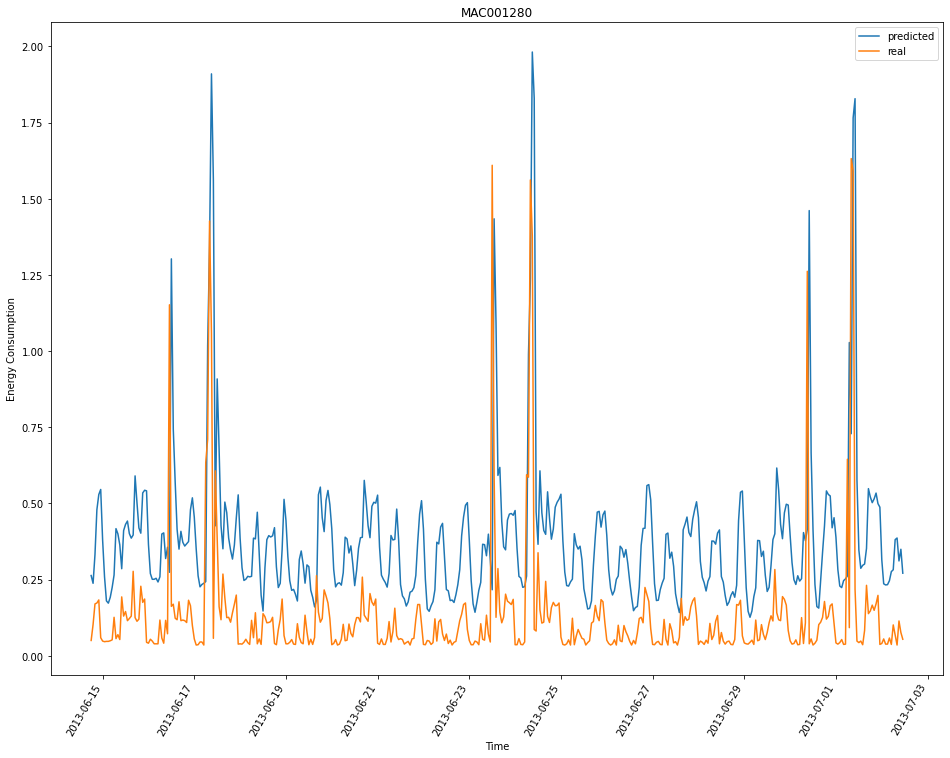

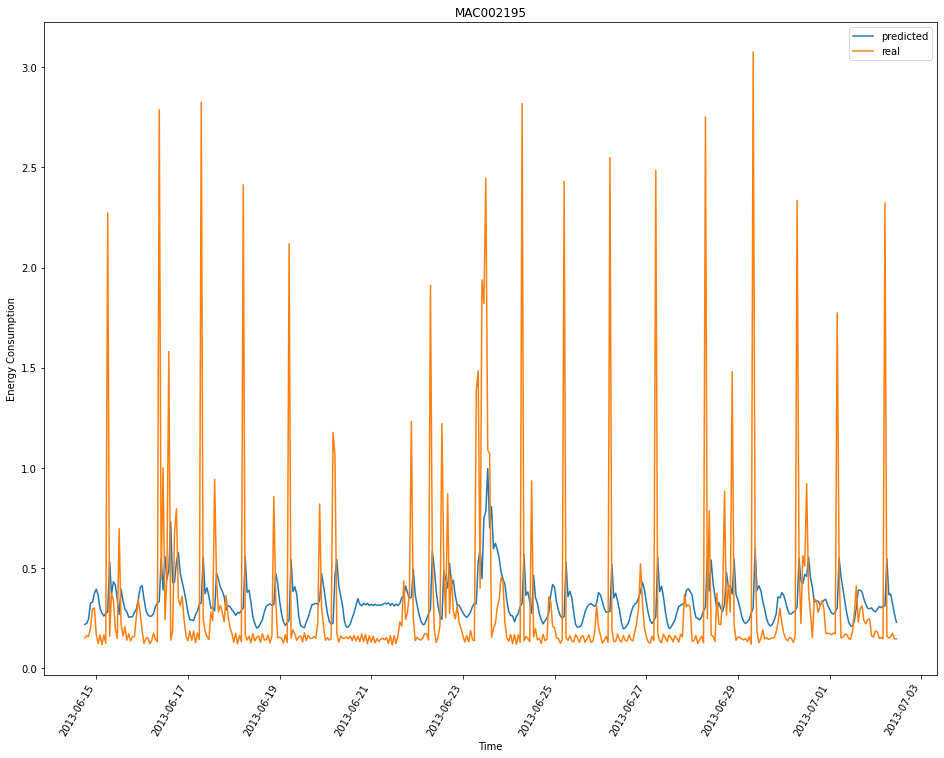

In [66]:
for cl in client_objects_short:
  pred = cl.pred_df.values
  true = cl.test.iloc[TIME_WINDOW_SIZE:, :].values

  x_ax = list(cl.test.iloc[TIME_WINDOW_SIZE:, :].index)
  #[i for i in range(len(pred))]
  mpl.rcParams['figure.figsize'] = (16, 12)

  plt.plot(x_ax, pred, label='predicted')
  plt.plot(x_ax, true, label='real')
  plt.xticks(rotation=60, ha='right')
  plt.title(cl.cid)
  plt.ylabel("Energy Consumption")
  plt.xlabel("Time")
  plt.legend()
  plt.show()
  #plt.savefig('MAC001811.png')
  #plt.close()